In [2]:
import numpy as np
import copy
from dipy.core.gradients import gradient_table
from dipy.data import get_fnames
from dipy.io.gradients import read_bvals_bvecs
from dipy.io.image import load_nifti, save_nifti
from dipy.segment.mask import median_otsu
from dipy.reconst.dti import TensorModel
from dipy.segment.mask import segment_from_cfa
from dipy.segment.mask import bounding_box
import dipy.reconst.cross_validation as xval
import dipy.reconst.dti as DTI
import dipy.reconst.csdeconv as CSD
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.ndimage.morphology import binary_dilation


/tmp/ipykernel_379919/44306461.py:16: DeprecationWarning: Please use `binary_dilation` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_dilation


In [137]:
class SNRMetric(object):

    def __init__(self, bvals, bvecs) -> None:
        self.gtab = gradient_table(bvals, bvecs)
        self.tenmodel = TensorModel(self.gtab)

    def eval(self, data):
        _, self.mask = median_otsu(data, vol_idx=[0])
        tensorfit = self.tenmodel.fit(data)

        threshold = (0.6, 1, 0, 0.1, 0, 0.1)
        CC_box = np.zeros_like(data[..., 0])

        mins, maxs = bounding_box(self.mask)
        mins = np.array(mins)
        maxs = np.array(maxs)
        diff = (maxs - mins) // 4
        bounds_min = mins + diff
        bounds_max = maxs - diff

        CC_box[bounds_min[0]:bounds_max[0],
               bounds_min[1]:bounds_max[1],
               bounds_min[2]:bounds_max[2]] = 1

        mask_cc_part, cfa = segment_from_cfa(tensorfit, CC_box, threshold,
                                             return_cfa=True)
        mask_cc_part = mask_cc_part

        mean_signal = np.mean(data[mask_cc_part], axis=0)

        mask_noise = binary_dilation(self.mask, iterations=10)
        mask_noise[..., :mask_noise.shape[-1]//2] = 1
        mask_noise = ~mask_noise

        noise_std = np.std(data[mask_noise, :])
        return mean_signal, noise_std

In [238]:
class MRIMetrics():
    def __init__(self, bvals, bvecs, raw_data):
        self.gtab = self.gtab = gradient_table(bvals, bvecs)
        self.dti_model = DTI.TensorModel(self.gtab)
        self.raw_data = raw_data
        self.raw_data_slice = None
        _, self.mask = median_otsu(raw_data, vol_idx=[0, 1])

    def fit_model(self, data):
        response, ratio = CSD.auto_response_ssst(self.gtab, data, roi_radii=10, fa_thr=0.7)
        csd_model = CSD.ConstrainedSphericalDeconvModel(self.gtab, response)
        return csd_model, response

    def pearsonr(self, data, dti):
        return stats.pearsonr(data, dti)[0] ** 2

    def eval(self, data_slice, csd_model, response):

        dti_slice = xval.kfold_xval(self.dti_model, data_slice, 2)
        csd_slice = xval.kfold_xval(csd_model, data_slice, 2, response)
        print(self.raw_data_slice.shape, dti_slice.shape)

        r2s_dti = []
        for i in range(0, dti_slice.shape[0]):
            for j in range(0, dti_slice.shape[1]):
                for k in range(0, dti_slice.shape[2]):
                    dti_r2 = stats.pearsonr(data_slice[i, j, k], dti_slice[i, j, k])[0] ** 2
                    r2s_dti.append(dti_r2)
        r2s_dti = np.array(r2s_dti)
        r2s_dti = r2s_dti[~np.isnan(r2s_dti)]

        r2s_csd = []
        for i in range(0, csd_slice.shape[0]):
            for j in range(0, csd_slice.shape[1]):
                for k in range(0, csd_slice.shape[2]):
                    csd_r2 = stats.pearsonr(data_slice[i, j, k], csd_slice[i, j, k])[0] ** 2
                    r2s_csd.append(csd_r2)
        r2s_csd = np.array(r2s_csd)
        r2s_csd = r2s_csd[~np.isnan(r2s_csd)]

        return r2s_dti, r2s_csd

    def calc(self, data, slice=38):
        csd_model, response = self.fit_model(data)

        data_masked = copy.deepcopy(data)

        if slice is not None:
            data_masked = data_masked[..., slice:slice+1, :]
            data_masked[self.mask[..., slice:slice+1] == 0] = 0
            self.raw_data_slice = self.raw_data[..., slice:slice+1, :]
            self.raw_data_slice[self.mask[..., slice:slice+1] == 0] = 0

        dti, csd = self.eval(data_masked, csd_model, response)

        return dti, csd

In [4]:
def norm_data(data):
    min_data = np.min(data, axis=(0,1,2), keepdims=True)
    max_data = np.max(data, axis=(0,1,2), keepdims=True)
    return (data.astype(np.float32) - min_data) / (max_data - min_data)

In [5]:
hardi_fname = 'dataset/stanford_hardi/HARDI150.nii.gz'
hardi_bval_fname = 'dataset/stanford_hardi/HARDI150.bval'
hardi_bvec_fname = 'dataset/stanford_hardi/HARDI150.bvec'

data, affine = load_nifti(hardi_fname)
data = norm_data(data)
bvals, bvecs = read_bvals_bvecs(hardi_bval_fname, hardi_bvec_fname)
voxel_mask = [0] + list(range(10, 160))
# voxel_mask = list(range(10, 160))
data = data[..., voxel_mask]
bvals = bvals[voxel_mask]
bvecs = bvecs[voxel_mask]
print(data.shape)

our_data, affine = load_nifti('experiments/hardi150_denoise_230430_115119_control/results/hardi150_denoised.nii.gz')
our_data = norm_data(our_data)
our_data = np.concatenate([data[..., [0]], our_data], axis=-1)
print(our_data.shape)

ddm_data, affine = load_nifti('experiments/hardi150_denoise_230426_211632_baseline/results/hardi150_denoised.nii.gz')
ddm_data = norm_data(ddm_data)
ddm_data = np.concatenate([data[..., [0]], ddm_data], axis=-1)
print(ddm_data.shape)

ddim_data, affine = load_nifti('experiments/hardi150_denoise_230430_033002_ddim/results/hardi150_denoised.nii.gz')
ddim_data = norm_data(ddim_data)
ddim_data = np.concatenate([data[..., [0]], ddim_data], axis=-1)
print(ddim_data.shape)

p2s_data, affine = load_nifti('experiments/hardi150_p2s/denoised_StanfordHardi_p2s_mlp.nii.gz')
p2s_data = norm_data(p2s_data)
p2s_data = np.concatenate([data[..., [0]], p2s_data[..., 10:160]], axis=-1)
print(p2s_data.shape)

(81, 106, 76, 151)
(81, 106, 76, 151)
(81, 106, 76, 151)
(81, 106, 76, 151)
(81, 106, 76, 151)


In [210]:
M = SNRMetric(bvals, bvecs)

In [139]:
snr, std = M.eval(data)
print(np.mean(snr), std)

ddm_snr, ddm_std = M.eval(ddm_data)
print(np.mean(ddm_snr), ddm_std)

ddim_snr, ddim_std = M.eval(ddim_data)
print(np.mean(ddim_snr), ddim_std)

our_snr, our_std = M.eval(our_data)
print(np.mean(our_snr), our_std)

0.12262054 0.009125202
0.10491611 0.0082704965
0.098483495 0.008887185
0.10788838 0.008703155


In [239]:
M = MRIMetrics(bvals, bvecs, data)

In [240]:
dti, csd = M.calc(data, slice=38)
ddm_dti, ddm_csd = M.calc(ddm_data, slice=38)
ddim_dti, ddim_csd = M.calc(ddim_data, slice=38)
our_dti, our_csd = M.calc(our_data, slice=38)
p2s_dti, p2s_csd = M.calc(p2s_data, slice=38)

100%|██████████| 8586/8586 [00:01<00:00, 6889.50it/s] 


(81, 106, 1, 151) (81, 106, 1, 151)


100%|██████████| 8586/8586 [00:01<00:00, 6329.72it/s] 


(81, 106, 1, 151) (81, 106, 1, 151)


100%|██████████| 8586/8586 [00:01<00:00, 5863.51it/s] 


(81, 106, 1, 151) (81, 106, 1, 151)


100%|██████████| 8586/8586 [00:01<00:00, 7693.31it/s] 


(81, 106, 1, 151) (81, 106, 1, 151)


100%|██████████| 8586/8586 [00:01<00:00, 7208.64it/s] 


(81, 106, 1, 151) (81, 106, 1, 151)


In [241]:
print(np.mean(dti), np.mean(csd))
print(np.mean(ddm_dti), np.mean(ddm_csd))
print(np.mean(ddim_dti), np.mean(ddim_csd))
print(np.mean(our_dti), np.mean(our_csd))
print(np.mean(p2s_dti), np.mean(p2s_csd))

0.11259480362575569 0.45207814093802956
0.35253953013599915 0.7019719084754231
0.30090424554697326 0.3962872661949114
0.22503216071100723 0.7293541353076686
0.1840523799750616 0.6934431336901034


In [242]:
dtis = [dti, ddm_dti, ddim_dti, our_dti, p2s_dti]
csds = [csd, ddm_csd, ddim_csd, our_csd, p2s_csd]
max_len = np.max([len(dti), len(ddm_dti), len(ddim_dti), len(p2s_dti), len(our_dti)])


for i in range(5):
    if len(dtis[i]) < max_len:
        padding = max_len - len(dtis[i])
        dtis[i] = np.pad(dtis[i], (0, padding), mode='mean')
        csds[i] = np.pad(csds[i], (0, padding), mode='mean')
dti, ddm_dti, ddim_dti, our_dti, p2s_dti = dtis
csd, ddm_csd, ddim_csd, our_csd, p2s_csd = csds

In [243]:
print(np.mean(p2s_dti - dti))
print(np.std(p2s_dti - dti))

print(np.mean(ddm_dti - dti))
print(np.std(ddm_dti - dti))

print(np.mean(ddim_dti - dti))
print(np.std(ddim_dti - dti))

print(np.mean(our_dti - dti))
print(np.std(our_dti - dti))

0.07145757634930591
0.20782900963909554
0.2399447265102435
0.28665030256287116
0.1883094419212175
0.2573293282471943
0.11243735708525156
0.2507108145944056


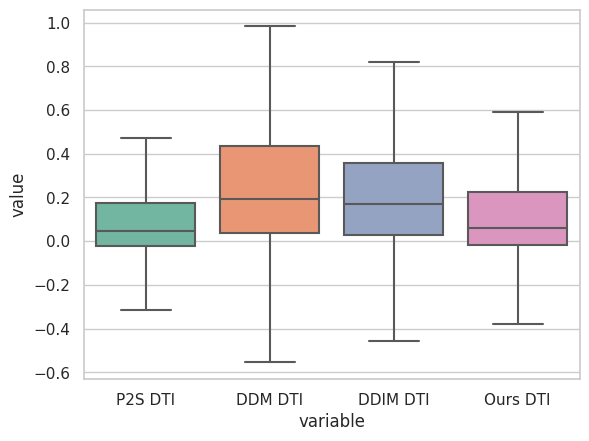

In [244]:
%matplotlib inline
import seaborn as sns
import pandas as pd

p2s_diff = p2s_dti - dti
# p2s_diff = p2s_diff[p2s_diff != 0]
ddm_diff = ddm_dti - dti
# ddm_diff = ddm_diff[ddm_diff != 0]
ddim_diff = ddim_dti - dti
# ddim_diff = ddim_diff[ddim_diff != 0]
our_diff = our_dti - dti
# our_diff = our_diff[our_diff != 0]

df_diff = pd.DataFrame({'P2S DTI':p2s_diff,
                        'DDM DTI':ddm_diff,
                        'DDIM DTI':ddim_diff,
                        'Ours DTI':our_diff})

sns.set(style="whitegrid")
ax = sns.boxplot(x="variable", y="value", data=pd.melt(df_diff), fliersize=0, sym='', palette="Set2")

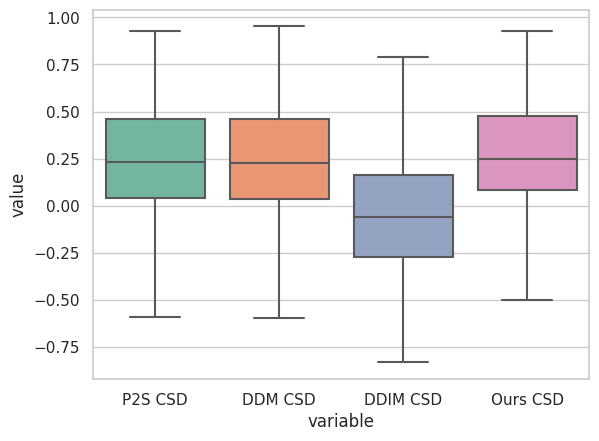

In [245]:
df_diff = pd.DataFrame({'P2S CSD':p2s_csd - csd,
                        'DDM CSD':ddm_csd - csd,
                        'DDIM CSD':ddim_csd - csd,
                        'Ours CSD':our_csd - csd})

sns.set(style="whitegrid")
ax = sns.boxplot(x="variable", y="value", data=pd.melt(df_diff), fliersize=0, sym='', palette="Set2")

In [6]:
canny, affine = load_nifti('dataset/stanford_hardi/HARDI150_canny.nii.gz')
voxel_mask = [0] + list(range(10, 160))
canny = canny[..., voxel_mask]
canny = norm_data(canny)

p2s_canny, affine = load_nifti('experiments/hardi150_p2s/denoised_StanfordHardi_p2s_mlp_canny.nii.gz')
voxel_mask = [0] + list(range(10, 160))
p2s_canny = p2s_canny[..., voxel_mask]
p2s_canny = norm_data(p2s_canny)

ddm_canny, affine = load_nifti('experiments/hardi150_denoise_230426_211632_baseline/results/hardi150_denoised_canny.nii.gz')
ddm_canny = np.concatenate((canny[..., [0]], ddm_canny), axis=-1)
ddm_canny = norm_data(ddm_canny)

ddim_canny, affine = load_nifti('experiments/hardi150_denoise_230430_033002_ddim/results/hardi150_denoised_canny.nii.gz')
ddim_canny = np.concatenate((canny[..., [0]], ddim_canny), axis=-1)
ddim_canny = norm_data(ddim_canny)

our_canny, affine = load_nifti('experiments/hardi150_denoise_230430_115119_control/results/hardi150_denoised_canny.nii.gz')
our_canny = np.concatenate((canny[..., [0]], our_canny), axis=-1)
our_canny = norm_data(our_canny)

In [7]:
from skimage.metrics import structural_similarity as ssim
slice = 40

ssim_scores_p2s = []
for slice in range(10, canny.shape[-2]-10):
    for i in range(canny.shape[-1]):
        score = 0
        score += ssim(p2s_canny[..., slice:slice+1, i].squeeze(), canny[..., slice:slice+1, i].squeeze(), data_range=1)
        # score += ssim(p2s_data[..., slice:slice+1, i].squeeze(), data[..., slice:slice+1, i].squeeze(), data_range=1, gaussian_weights=True)
        ssim_scores_p2s.append(score)
ssim_scores_p2s = np.array(ssim_scores_p2s)

ssim_scores_ddm = []
for slice in range(10, canny.shape[-2]-10):
    for i in range(canny.shape[-1]):
        score = 0
        score += ssim(ddm_canny[..., slice:slice+1, i].squeeze(), canny[..., slice:slice+1, i].squeeze(), data_range=1)
        # score += ssim(ddm_data[..., slice:slice+1, i].squeeze(), data[..., slice:slice+1, i].squeeze(), data_range=1, gaussian_weights=True)
        ssim_scores_ddm.append(score)
ssim_scores_ddm = np.array(ssim_scores_ddm)

ssim_scores_ddim = []
for slice in range(10, canny.shape[-2]-10):
    for i in range(canny.shape[-1]):
        score = 0
        score += ssim(ddim_canny[..., slice:slice+1, i].squeeze(), canny[..., slice:slice+1, i].squeeze(), data_range=1)
        # score += ssim(ddim_data[..., slice:slice+1, i].squeeze(), data[..., slice:slice+1, i].squeeze(), data_range=1, gaussian_weights=True)
        ssim_scores_ddim.append(score)
ssim_scores_ddim = np.array(ssim_scores_ddim)

ssim_scores_our = []
for slice in range(10, canny.shape[-2]-10):
    for i in range(canny.shape[-1]):
        score = 0
        score += ssim(our_canny[..., slice:slice+1, i].squeeze(), canny[..., slice:slice+1, i].squeeze(), data_range=1)
        # score += ssim(our_data[..., slice:slice+1, i].squeeze(), data[..., slice:slice+1, i].squeeze(), data_range=1, gaussian_weights=True)
        ssim_scores_our.append(score)
ssim_scores_our = np.array(ssim_scores_our)


print(np.mean(ssim_scores_p2s))
print(np.mean(ssim_scores_ddm))
print(np.mean(ssim_scores_ddim))
print(np.mean(ssim_scores_our))

0.6940064534090395
0.6035228562212782
0.5001706315472938
0.7215874725408581


In [135]:
hardi_fname = 'dataset/stanford_hardi/HARDI150.nii.gz'
hardi_bval_fname = 'dataset/stanford_hardi/HARDI150.bval'
hardi_bvec_fname = 'dataset/stanford_hardi/HARDI150.bvec'

data, affine = load_nifti(hardi_fname)
data = norm_data(data)
bvals, bvecs = read_bvals_bvecs(hardi_bval_fname, hardi_bvec_fname)
voxel_mask = [0] + list(range(10, 160))
# voxel_mask = list(range(10, 160))
data = data[..., voxel_mask]
bvals = bvals[voxel_mask]
bvecs = bvecs[voxel_mask]

our_data, affine = load_nifti('experiments/hardi150_denoise_230430_115119_control/results/hardi150_denoised.nii.gz')
our_data = norm_data(our_data)
our_data = np.concatenate([data[..., [0]], our_data], axis=-1)


ddm_data, affine = load_nifti('experiments/hardi150_denoise_230426_211632_baseline/results/hardi150_denoised.nii.gz')
ddm_data = norm_data(ddm_data)
ddm_data = np.concatenate([data[..., [0]], ddm_data], axis=-1)

In [112]:
# data = our_data
data = ddm_data
gtab = gradient_table(bvals, bvecs)

print('Computing brain mask...')
b0_mask, mask = median_otsu(data, vol_idx=[0])

print('Computing tensors...')
tenmodel = TensorModel(gtab)
tensorfit = tenmodel.fit(data, mask=mask)

Computing brain mask...
Computing tensors...


Computing worst-case/best-case SNR using the corpus callosum...


/tmp/ipykernel_278308/3204198753.py:36: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "cmap" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig("./tmp/CC_segmentation.png", bbox_inches='tight', cmap='plasma')


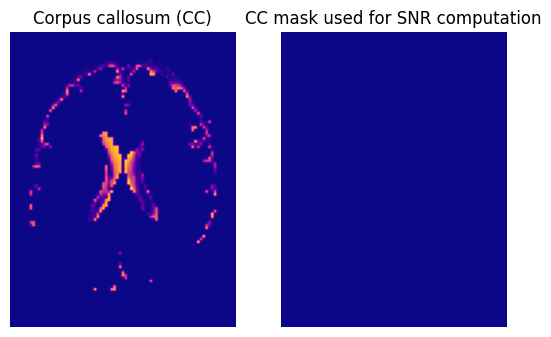

In [119]:
print('Computing worst-case/best-case SNR using the corpus callosum...')

threshold = (0.6, 1, 0, 0.1, 0, 0.1)
CC_box = np.zeros_like(data[..., 0])

mins, maxs = bounding_box(mask)
mins = np.array(mins)
maxs = np.array(maxs)
diff = (maxs - mins) // 4
bounds_min = mins + diff
bounds_max = maxs - diff

CC_box[bounds_min[0]:bounds_max[0],
       bounds_min[1]:bounds_max[1],
       bounds_min[2]:bounds_max[2]] = 1

mask_cc_part, cfa = segment_from_cfa(tensorfit, CC_box, threshold,
                                     return_cfa=True)

save_nifti('./tmp/cfa_CC_part.nii.gz', (cfa*255).astype(np.uint8), affine)
save_nifti('./tmp/mask_CC_part.nii.gz', mask_cc_part.astype(np.uint8), affine)


region = 40
fig = plt.figure('Corpus callosum segmentation')
plt.subplot(1, 2, 1)
plt.title("Corpus callosum (CC)")
plt.axis('off')
red = cfa[..., 0]
plt.imshow(np.rot90(red[:, :, region]), cmap='plasma')

plt.subplot(1, 2, 2)
plt.title("CC mask used for SNR computation")
plt.axis('off')
plt.imshow(np.rot90(mask_cc_part[:, :, region]), cmap='plasma')
fig.savefig("./tmp/CC_segmentation.png", bbox_inches='tight', cmap='plasma')

In [120]:
mean_signal = np.mean(data[mask_cc_part], axis=0)

In [121]:
np.sum(mask_cc_part)

18

In [116]:
mask_noise = binary_dilation(mask, iterations=10)
mask_noise[..., :mask_noise.shape[-1]//2] = 1
mask_noise = ~mask_noise

save_nifti('mask_noise.nii.gz', mask_noise.astype(np.uint8), affine)

noise_std = np.std(data[mask_noise, :])
print('Noise standard deviation sigma= ', noise_std)

Noise standard deviation sigma=  0.0082704965


In [55]:
idx = np.sum(gtab.bvecs, axis=-1) == 0
gtab.bvecs[idx] = np.inf
axis_X = np.argmin(np.sum((gtab.bvecs-np.array([1, 0, 0]))**2, axis=-1))
axis_Y = np.argmin(np.sum((gtab.bvecs-np.array([0, 1, 0]))**2, axis=-1))
axis_Z = np.argmin(np.sum((gtab.bvecs-np.array([0, 0, 1]))**2, axis=-1))

for direction in [0, axis_X, axis_Y, axis_Z]:
    SNR = mean_signal[direction]/noise_std
    if direction == 0:
        print("SNR for the b=0 image is :", SNR)
    else:
        print("SNR for direction", direction, " ",
              gtab.bvecs[direction], "is :", SNR)

SNR for the b=0 image is : nan
SNR for direction 49   [ 0.98875  0.1177  -0.09229] is : nan
SNR for direction 48   [-0.05039    0.99871    0.0054406] is : nan
SNR for direction 117   [-0.11825  -0.039925  0.99218 ] is : nan
